In [68]:
# Imports for the Maptek Python SDK and additional libraries.
import collections
import copy
import ctypes
import fractions
import math
import time
from collections import defaultdict
from itertools import islice

import matplotlib as mpl
import matplotlib.colors as cc

# mpl.use('agg')
import matplotlib.pyplot as cm
import numpy as np
import pandas as pd
import seaborn as sns
from mapteksdk.data import (
    DenseBlockModel,
    GridSurface,
    NumericColourMap,
    SubblockedBlockModel,
    Surface,
    Text3D,
)
from mapteksdk.project import Project
from matplotlib.ticker import PercentFormatter
from matplotlib.widgets import Button, CheckButtons, RadioButtons
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_gui
from tqdm.notebook import tqdm, trange

cm.rcParams["font.family"] = ["Source Han Sans TW", "monospace"]
cm.rcParams["font.size"] = 14

# Connect to the currently running Maptek Project.
project = Project()
# project.mcp_instance.mcp_dict['PRODUCT_LOCATION_INFO']  # Report out which application it connected to (Optional)

In [75]:
# Initialisation
selected_model = None
selected_var = ""
colours = ""
real_colours = []
vis = ""
# ****************Bool swicthes for certain features*****************************************************************
vis_compiler = False
point_checker = True
# ********************************************************************************************************************
names = []
df = pd.DataFrame()
selection = project.get_selected()
last_opacity = 255

# For getting colours and the mapped names used in the model visualisation
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
with project.edit("legends/Domain 2") as legend:
    colours = legend.colours
    colour_names = legend.legend
    colour_names = [each_string.lower() for each_string in colour_names]
# Getting hex values of the colours
colours = colours / 255
for z in range(0, len(colour_names), 1):
    real_colours.append(cc.to_hex(colours[z], keep_alpha=True))

# Creating the array for storing data to be retrieved
N = len(colour_names)
global M
M = len(selection)
values = [[0 for i in range(M)] for j in range(N)]
vis_collection = [0] * M
var_collection = [0] * M
index_map = [0] * M
extents = [[] for _ in range(M)]
# i tells you the index of the block_model
i = 0
j = 0


# DATA GETTER

for item in selection:
    print(item.name)
    # Setting outer array back to 0, for new block
    j = 0
    nn = 0
    if item.is_a(DenseBlockModel) or item.is_a(SubblockedBlockModel):
        selected_model = item
        # Checker for point stuff
        if point_checker:
            # Getting all block details
            with project.edit(selected_model) as bm:

                block_sizes = bm.block_sizes
                block_centroids = bm.block_centroids
                b = bm.block_resolution
                x_res = float(b[0])
                y_res = float(b[1])
                z_res = float(b[2])

                x_count = bm.column_count
                y_count = bm.row_count
                z_count = bm.slice_count

                totallength_x_dimension = x_res * x_count
                totallength_y_dimension = y_res * y_count
                totallength_z_dimension = z_res * z_count

                index_map[i] = bm.block_to_grid_index
                index_map[i] = index_map[i].tolist()
                number_of_parent_blocks = len(np.unique(index_map[i], axis=0))
                total_volume_of_block = number_of_parent_blocks * x_res * y_res * z_res

                # Converting from world coordinates
                block_centroids = bm.convert_to_block_coordinates(block_centroids)
                block_centroids = block_centroids + 0.5 * np.array(
                    [x_res, y_res, z_res]
                )
                # Getting sample point data for point to block comparison
                point_location = "samples/res Intervals Table mid points"
                with project.read(point_location) as points:
                    # SDK method
                    real_points = points.points
                    point_visibility = points.point_visibility
                    real_points = bm.convert_to_block_coordinates(real_points)
                    real_points = real_points + 0.5 * np.array([x_res, y_res, z_res])
                    point_collection = [0] * len(real_points)
                    point_domains = points.point_attributes[
                        '{"c":"Domain","n":[],"s":"Point attribute (text)","t":"Tstring","u":"dimensionless","v":3}'
                    ]

                # *************************************************************************************************
                # Brute-force method
                print("Calculating block extents")

                for nn, useless_var in enumerate(block_centroids):
                    # print(len(extents[0]))
                    # print(len(extents[1]))
                    extents[i].append((
                        [
                            (block_centroids[nn] - block_sizes[nn] / 2).tolist(),
                            (block_centroids[nn] + block_sizes[nn] / 2).tolist(),
                        ]
                    ))

                print(len(extents[0]))
                print(len(extents[1]))
                # *************************************************************************************************
                # # Checks all attributes of block and then chooses the one with discrete values
                a_dict = bm.block_attributes.names
                for key in a_dict:
                    checker = bm.block_attributes[key]
                    if isinstance(checker[0], (str, int)):
                        selected_var = checker
                        var_collection[i] = selected_var
                vis = bm.block_visibility
                vis_collection[i] = vis
                for domain in colour_names:
                    values[j][i] = np.count_nonzero(selected_var == domain)
                    j = j + 1
                # Creating labels
                names.append("Block" + str(i))
                # For the confusion matrix
                df["block" + str(i)] = pd.Series(selected_var)
                i = i + 1


# Getting "number of blocks" and the cooridnates of all those blocks
# in the subblock model created for subblock-subblock comparison
# ###################################################################################################################
x_for_created_subblock = fractions.gcd(1.5, 1.5)
y_for_created_subblock = fractions.gcd(1.5, 1.5)
z_for_created_subblock = fractions.gcd(1.5, 1.5)
number_of_blocks_in_created_subblock_model = (total_volume_of_block) / (
    x_for_created_subblock * y_for_created_subblock * z_for_created_subblock
)

new_subblock_count_x_direction = totallength_x_dimension / x_for_created_subblock
new_subblock_count_y_direction = totallength_y_dimension / y_for_created_subblock
new_subblock_count_z_direction = totallength_z_dimension / z_for_created_subblock

new_x_centroid_coordinate = np.linspace(
    x_for_created_subblock / 2,
    (new_subblock_count_x_direction * x_for_created_subblock)
    + x_for_created_subblock / 2,
    int(new_subblock_count_x_direction),
    endpoint=False,
)

new_y_centroid_coordinate = np.linspace(
    y_for_created_subblock / 2,
    (new_subblock_count_y_direction * y_for_created_subblock)
    + y_for_created_subblock / 2,
    int(new_subblock_count_y_direction),
    endpoint=False,
)

new_z_centroid_coordinate = np.linspace(
    z_for_created_subblock / 2,
    (new_subblock_count_z_direction * z_for_created_subblock)
    + z_for_created_subblock / 2,
    int(new_subblock_count_z_direction),
    endpoint=False,
)


all_new_x_coordinates, all_new_y_coordinates, all_new_z_coordinates = np.meshgrid(
    new_x_centroid_coordinate,
    new_y_centroid_coordinate,
    new_z_centroid_coordinate,
    indexing="ij",
)

new_block_centroids = np.column_stack(
    (
        all_new_x_coordinates.flatten(),
        all_new_y_coordinates.flatten(),
        all_new_z_coordinates.flatten(),
    )
)

# ###################################################################################################################

# Visibility filterer
if vis_compiler:
    visfinal = vis_collection[0]
    for q in range(1, len(vis_collection), 1):
        visfinal = visfinal & vis_collection[q]

    # The statement below removes all values in selected_var which have a corresponding false value
    # in the same index location in vis
    for z in range(0, len(var_collection), 1):
        var_collection[z] = np.array(var_collection[z])[visfinal]

    for d in range(0, M, 1):
        # For the confusion matrix
        df["block" + str(d)] = pd.Series(var_collection[d])
        for domain, k in zip(colour_names, range(0, len(colour_names), 1)):
            values[k][d] = np.count_nonzero(var_collection[d] == domain)
# For the confusion matrix

df.dropna(inplace=True)

# For future operations
# extents.tolist()

CORE1
Calculating block extents
3889872
0
CORE2
Calculating block extents
3889872
3889872


TypeError: 'float' object cannot be interpreted as an integer

In [70]:
len(extents[1])

952

In [118]:
unique_rows = np.unique(index_map, axis=0)
print("Number of parent blocks:")
print(len(unique_rows))

Number of parent blocks:
8


In [71]:
# SUB-BLOCK TO SUB-BLOCK COMPARISON
created_centroid_pos_in_orignal_block = collections.defaultdict(
    lambda: collections.defaultdict(dict)
)
domains_of_created_block_centroids = collections.defaultdict(
    lambda: collections.defaultdict(dict)
)
lengths_of_subblock_indices_for_orignal_block = [[]] * M
subblock_exists_for_orignal_block = 0
outside_count_created_block = 0
string_not_found = 0
check = 0
outside_indices_created_block = []

for block_model_index, item in enumerate(selection):
    # print(block_model_index)
    # print((domains_of_created_block_centroids[0]))
    # print((domains_of_created_block_centroids[1]))
    selected_model = item
    print(item.name)
    if item.is_a(DenseBlockModel) or item.is_a(SubblockedBlockModel):
        with project.edit(selected_model) as bm:
            for created_block_crawler, created_block_value in tqdm(
                enumerate(new_block_centroids),
                total=len(new_block_centroids),
                desc="Progress",
                ncols=500,
                ascii="**",
            ):
                index_x_of_created_centroid = math.floor(created_block_value[0] / x_res)
                index_y_of_created_centroid = math.floor(created_block_value[1] / y_res)
                index_z_of_created_centroid = math.floor(created_block_value[2] / z_res)

                index_of_created_centroid = index_map[block_model_index].index(
                    [
                        index_x_of_created_centroid,
                        index_y_of_created_centroid,
                        index_z_of_created_centroid,
                    ]
                )
                # print(index)
                subblock_check_for_orignal_block = bm.grid_index(
                    [
                        index_x_of_created_centroid,
                        index_y_of_created_centroid,
                        index_z_of_created_centroid,
                    ]
                )
                # print(subblock_check_for_orignal_block)
                subblock_indices_for_orignal_block = []
                subblock_indices_for_orignal_block = np.where(
                    subblock_check_for_orignal_block
                )[0]
                # print(subblock_indices_for_orignal_block)
                lengths_of_subblock_indices_for_orignal_block[block_model_index].append(
                    (len(subblock_indices_for_orignal_block), created_block_crawler)
                )
                if len(subblock_indices_for_orignal_block) > 0:
                    subblock_exists_for_orignal_block += 1
                    for subblock_crawler in subblock_indices_for_orignal_block:
                        check += 1
                        if (
                            (
                                extents[block_model_index][subblock_crawler][0][0]
                                <= created_block_value[0]
                                <= extents[block_model_index][subblock_crawler][1][0]
                            )
                            and (
                                extents[block_model_index][subblock_crawler][0][1]
                                <= created_block_value[1]
                                <= extents[block_model_index][subblock_crawler][1][1]
                            )
                            and (
                                extents[block_model_index][subblock_crawler][0][2]
                                <= created_block_value[2]
                                <= extents[block_model_index][subblock_crawler][1][2]
                            )
                        ):

                            created_centroid_pos_in_orignal_block[block_model_index][
                                created_block_crawler
                            ] = subblock_crawler
                            # print(block_model_index)
                            domains_of_created_block_centroids[block_model_index][
                                created_block_crawler
                            ] = var_collection[block_model_index][subblock_crawler]

                            # print(str(len(domains_of_created_block_centroids[1])) +"," + str(created_block_crawler))
                            break

Subblocked-200m-new-one 10-1-2022 09:57


Progress:   0%|                                                                                               …

Subblocked-200m-second-new-one 12-1-2022 15:09


Progress:   0%|                                                                                               …

In [83]:
len(domains_of_created_block_centroids[0])

4096

In [48]:
# POINT TO BLOCK/SUB-BLOCK COMPARISON
point_pos1 = {}
points_that_dont_match = []
points_that_match = []
domains_of_blocks = []
outside_count = 0
subblock_exists = 0
outside_indices = []
point_in_sublock = []
lengths_of_subblock_indices = []
number_of_checks_happening_per_block = []
samplepoints_crawler = 0
check = 0
pointnotfound_in_indices_givenbygridindex = []
with project.read(selected_model) as bm:
    for samplepoints_crawler, samplepoints_value in tqdm(
        enumerate(real_points),
        total=len(real_points),
        desc="Progress",
        ncols=500,
        ascii="**",
    ):
        c1 = math.floor(samplepoints_value[0] / x_res)
        c2 = math.floor(samplepoints_value[1] / y_res)
        c3 = math.floor(samplepoints_value[2] / z_res)

        if (0 <= c1 < x_count) and (0 <= c2 < y_count) and (0 <= c3 < z_count):
            index = index_map[0].index([c1, c2, c3])
            # print(index)
            subblock_check = bm.grid_index([c1, c2, c3])
            # print(subblock_check)
            subblock_indices = []
            subblock_indices = np.where(subblock_check)[0]
            # print(subblock_indices)
            lengths_of_subblock_indices.append(
                (len(subblock_indices), samplepoints_crawler)
            )
            if len(subblock_indices) > 0:
                subblock_exists += 1
                for ex in subblock_indices:
                    check += 1
                    if (
                        (
                            extents[M-1][ex][0][0]
                            <= samplepoints_value[0]
                            <= extents[M-1][ex][1][0]
                        )
                        and (
                            extents[M-1][ex][0][1]
                            <= samplepoints_value[1]
                            <= extents[M-1][ex][1][1]
                        )
                        and (
                            extents[M-1][ex][0][2]
                            <= samplepoints_value[2]
                            <= extents[M-1][ex][1][2]
                        )
                    ):

                        number_of_checks_happening_per_block.append(
                            (check, samplepoints_crawler)
                        )
                        check = 0
                        point_in_sublock.append(ex)
                        point_pos1[samplepoints_crawler] = ex
                        domains_of_blocks.append(selected_var[ex])
                        break
                    elif check == len(subblock_indices):
                        check = 0
                        pointnotfound_in_indices_givenbygridindex.append(
                            samplepoints_crawler
                        )
        else:
            # print(c1, c2, c3)
            outside_count += 1
            outside_indices.append(samplepoints_crawler)
            continue


point_to_be_deleted_before_check = outside_indices
point_domains = [z.lower() for z in point_domains]
point_domains_wo_outliers = []
point_domains_wo_outliers = copy.deepcopy(point_domains)
# print(len(point_to_be_deleted_before_check))
# print((point_to_be_deleted_before_check)   )

point_domains_wo_outliers = np.delete(
    point_domains_wo_outliers, point_to_be_deleted_before_check
)

# This loop below is basically for findind how many blocks match or not, we are storing the indexes for
# getting their positions in the list where outsiders are already cut out
for points_index, (x, y) in enumerate(
    zip(point_domains_wo_outliers, domains_of_blocks)
):
    if x == y:
        points_that_match.append(points_index)
    else:
        points_that_dont_match.append(points_index)

# For getting positions of points which dont match with the blocks they are positioned in
point_pos_which_dont_match = copy.deepcopy(list(point_pos1.values()))
# Deleting all values which are matching, hencing leaving us with the positions where there is no matching
point_pos_which_dont_match = np.delete(point_pos_which_dont_match, points_that_match)


print("*******************")
print("*******************")
print("Number of points which do not match: " + str(len(points_that_dont_match)))
print("Number of points which match:: " + str(len(points_that_match)))
print("**********************************************************")

# print(len(point_domains_wo_outliers))
# print(len(domains_of_blocks))
# print("Blocks found: " + str(subblock_exists))
print("outside_count: " + str(outside_count))
print("*******************")

# print(point_domains_wo_outliers[:20])
# print(domains_of_blocks)
print("*******************")
print(
    "points not found inside block indices given by grid_index and their total number:"
)
print(pointnotfound_in_indices_givenbygridindex)
print(len(pointnotfound_in_indices_givenbygridindex))

Progress:   0%|                                                                                               …

*******************
*******************
Number of points which do not match: 749
Number of points which match:: 3098
**********************************************************
outside_count: 0
*******************
*******************
points not found inside block indices given by grid_index and their total number:
[]
0


In [12]:
# Only show BLOCKS which dont match their domain
block_array_of_visibility_created = []
with project.edit(selected_model) as bm:
    block_array_of_visibility = bm.block_visibility

    block_array_of_visibility_created = [False] * len(block_array_of_visibility)

    unique_blocks_which_contain_points_that_dont_match = set(point_pos_which_dont_match)

    for values in unique_blocks_which_contain_points_that_dont_match:
        block_array_of_visibility_created[values] = True
    bm.block_visibility = block_array_of_visibility_created

In [13]:
# Only show POINTS which dont match their domain
point_array_of_visibility_created = []
with project.edit(point_location) as points:
    point_array_of_visibility = points.point_visibility

    point_array_of_visibility_created = [False] * len(point_array_of_visibility)

    for values1 in points_that_dont_match:
        point_array_of_visibility_created[values1] = True
    points.point_visibility = point_array_of_visibility_created

In [14]:
# Gets previous visibilty back
with project.edit(point_location) as points:
    with project.edit(selected_model) as bm:
        bm.block_visibility = vis
        points.point_visibility = point_visibility

In [49]:
# STATISTICAL REPORT
df2 = pd.DataFrame()

match_percentage = str(
    round(((len(points_that_match) * 100) / len(point_domains_wo_outliers)), 2)
)

print(
    "From "
    + str(len(point_domains_wo_outliers))
    + " points (excluding "
    + str((outside_count))
    + " outliers, which were outside the block model) "
    + str(len(points_that_match))
    + " points were in the same block with the same domain"
    + " hence having a match percentage of "
    + match_percentage
)

print("The number of unique points:" + str(len(point_domains_wo_outliers)))
print("The number of unique blocks:" + str(len(set(list(point_pos1.values())))))

print(len(point_domains_wo_outliers))
print(len(domains_of_blocks))

df2["Points Domain"] = pd.Series(point_domains_wo_outliers)
df2["Block Domains"] = pd.Series(domains_of_blocks)

print(1 * "\n")
print("Point distribution in SAMPLE:")

# This helps gets percentage for each domain, as requested by richard
(point_domain_names, domain_frequencies) = np.unique(
    point_domains_wo_outliers, return_counts=True
)
(block_domain_names, block_domain_frequencies) = np.unique(
    domains_of_blocks, return_counts=True
)


print(df2["Points Domain"].value_counts())
for x, y in zip(point_domain_names, domain_frequencies):
    print(
        str(x)
        + ": "
        + str(round((y * 100) / (len(point_domains_wo_outliers)), 2))
        + " %"
    )

print(1 * "\n")
print("Point distribution in PREDICTED:")
print(df2["Block Domains"].value_counts())
for x, y in zip(block_domain_names, block_domain_frequencies):
    print(
        str(x)
        + ": "
        + str(round((y * 100) / (len(point_domains_wo_outliers)), 2))
        + " %"
    )

From 3847 points (excluding 0 outliers, which were outside the block model) 3098 points were in the same block with the same domain hence having a match percentage of 80.53
The number of unique points:3847
The number of unique blocks:250
3847
3847


Point distribution in SAMPLE:
ox            1924
pr            1182
pox            705
undomained      26
cvt             10
Name: Points Domain, dtype: int64
cvt: 0.26 %
ox: 50.01 %
pox: 18.33 %
pr: 30.73 %
undomained: 0.68 %


Point distribution in PREDICTED:
ox            1887
pr            1184
pox            764
undomained      12
Name: Block Domains, dtype: int64
ox: 49.05 %
pox: 19.86 %
pr: 30.78 %
undomained: 0.31 %


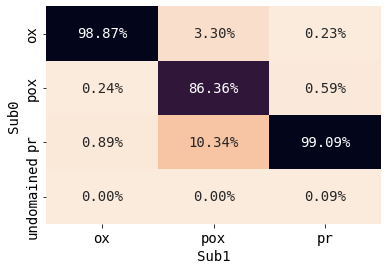

In [72]:
# CONFUSION MATRIX FOR SUB TO SUB COMPARISON

df3=pd.DataFrame()
gandu0=list(domains_of_created_block_centroids[0].values())
gandu1=list(domains_of_created_block_centroids[1].values())


df3["sub0"] = pd.Series(gandu0)
df3["sub1"] = pd.Series(gandu1)


point_confusion_matrix_for_sub = pd.crosstab(
    df3["sub0"], df3["sub1"], rownames=["Sub0"], colnames=["Sub1"]
)
point_confusion_matrix_for_sub = pd.DataFrame(point_confusion_matrix_for_sub)

mt = cm.figure(0)
gn = sns.heatmap(
    (point_confusion_matrix_for_sub) / (np.sum(point_confusion_matrix_for_sub)),
    cbar_kws={},
    annot=True,
    fmt=".2%",
    cmap="rocket_r",
    cbar=False,
)

cm.show()
# Uncomment the lines below to generate a report.
# print(
#     metrics.classification_report(
#         df["Points Domain"], df["Block Domains"], labels=colour_names, zero_division=1
#     )
# # )

In [74]:
print("Sub0:")
print(df3["sub0"].value_counts())


print(1 * "\n")
print("Sub1:")
print(df3["sub1"].value_counts())


Sub0:
pr            2247
ox            1255
pox            592
undomained       2
Name: sub0, dtype: int64


Sub1:
pr     2187
ox     1242
pox     667
Name: sub1, dtype: int64


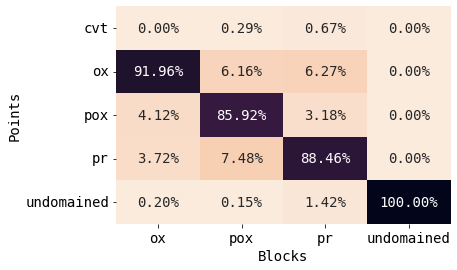

In [43]:
# CONFUSION MATRIX FOR POINT TO BLOCK COMPARISON
point_confusion_matrix = pd.crosstab(
    df2["Points Domain"], df2["Block Domains"], rownames=["Points"], colnames=["Blocks"]
)
point_confusion_matrix = pd.DataFrame(point_confusion_matrix)

mt = cm.figure(0)
gn = sns.heatmap(
    (point_confusion_matrix) / (np.sum(point_confusion_matrix)),
    cbar_kws={},
    annot=True,
    fmt=".2%",
    cmap="rocket_r",
    cbar=False,
)

cm.show()
# Uncomment the lines below to generate a report.
# print(
#     metrics.classification_report(
#         df["Points Domain"], df["Block Domains"], labels=colour_names, zero_division=1
#     )
# )

122
122


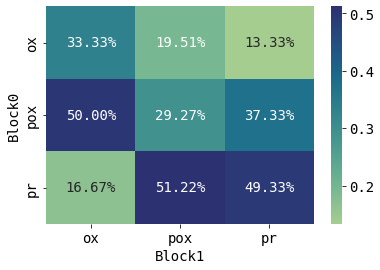

              precision    recall  f1-score   support

          ox       0.33      0.10      0.15        20
         pox       0.29      0.28      0.29        43
          pr       0.49      0.63      0.55        59
  undomained       1.00      1.00      1.00         0

   micro avg       0.42      0.42      0.42       122
   macro avg       0.53      0.50      0.50       122
weighted avg       0.40      0.42      0.39       122



In [90]:
# ****************CONFUSION MATRIX*****************************************************************

confusion_matrix1 = pd.crosstab(
    df["block0"], df["block1"], rownames=["Block0"], colnames=["Block1"]
)
confusion_matrix1 = pd.DataFrame(confusion_matrix1)

# confusion_matrix2 = confusion_matrix(df['block0'], df['block1'])

mt = cm.figure(0)
gn = sns.heatmap(
    (confusion_matrix1) / (np.sum(confusion_matrix1)),
    cbar_kws={},
    annot=True,
    fmt=".2%",
    cmap="crest",
    cbar=True,
)

# ***************************JUST DIFFERENT COLOURS, PLEASE IGNORE*****************************************************************
# mt1=cm.figure(1)
# gn=sns.heatmap((confusion_matrix1)/(np.sum(confusion_matrix1)),cbar_kws={},\
#             annot=True, fmt='.2%', cmap="YlGnBu",cbar=True)
# mt2=cm.figure(2)
# gn=sns.heatmap((confusion_matrix1)/(np.sum(confusion_matrix1)),cbar_kws={},\
#             annot=True, fmt='.2%', cmap="rocket_r",cbar=True)
# mt3=cm.figure(3)
# gn=sns.heatmap((confusion_matrix1)/(np.sum(confusion_matrix1)),cbar_kws={},\
#             annot=True, fmt='.2%', cmap="cubehelix_r",cbar=True)
# colorbar =gn.collections[0].colorbar
# colorbar.set_ticks([0,20,40,60,80,100])
# ^^^^^^^^^^^^^^^^^^^JUST DIFFERENT COLOURS, PLEASE IGNORE^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# mt1=cm.figure(1)
# sns.heatmap(confusion_matrix2/np.sum(confusion_matrix2), annot=True, fmt=.2%', cbar=True,\
# cbar_kws={'format':PercentFormatter()}, cmap="Blues")

cm.show()
# Uncomment the lines below to generate a report.
print(
    metrics.classification_report(
        df["block0"], df["block1"], labels=colour_names, zero_division=1
    )
)

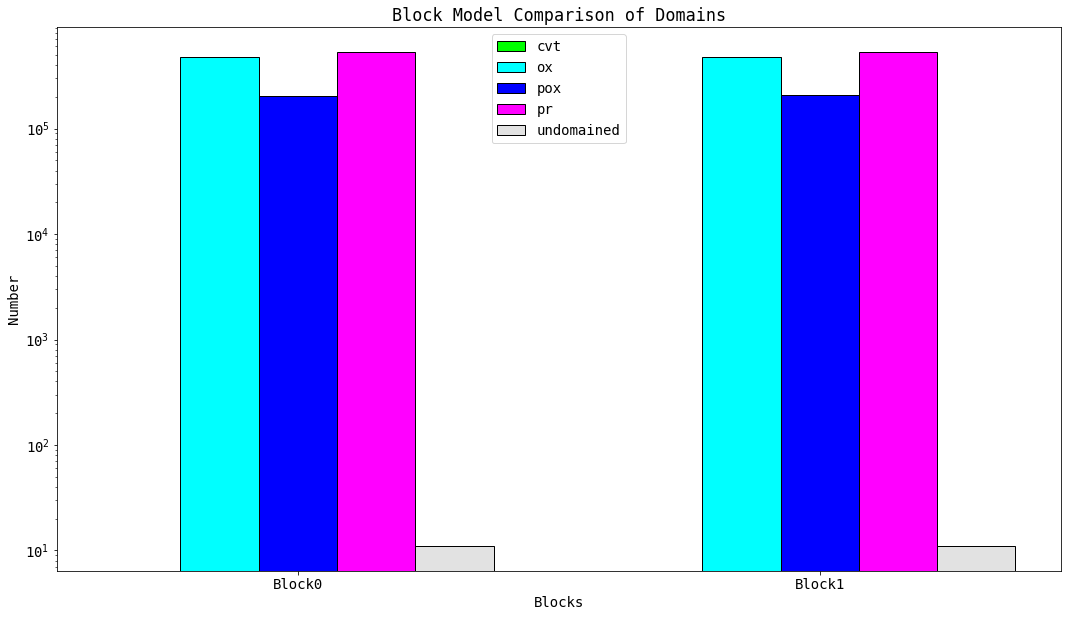

In [38]:
# *****************BAR PLOTS*****************************************************************
ind = np.arange(M)
width = 0.15
bar_names = {}

cm.figure(figsize=(18, 10))

for y in range(0, len(colour_names), 1):
    cm.bar(ind, values[y], width, color=real_colours[y], edgecolor="black", log=True)
    ind = ind + width

cm.xlabel("Blocks")
cm.ylabel("Number")
cm.title("Block Model Comparison of Domains")

cm.xticks(ind - 3 * width, names)
# cm.ticklabel_format(axis="y",style="plain")
cm.legend(colour_names)
cm.show()

# *************************************************************************************************

# seaborn stuff
# sns.barplot(names, values)

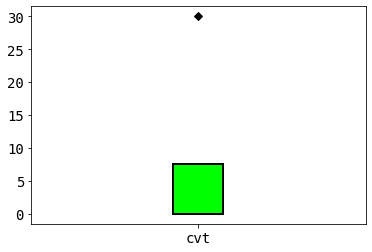

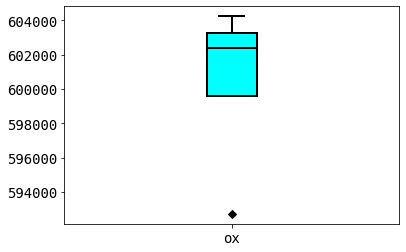

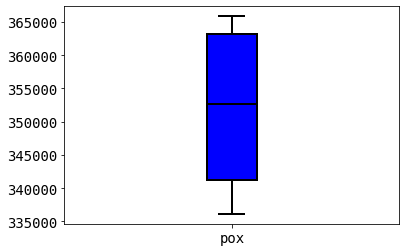

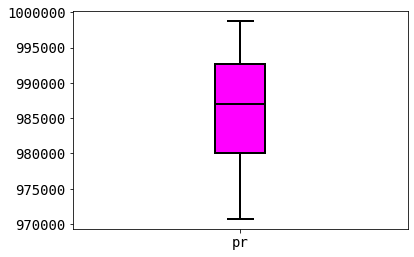

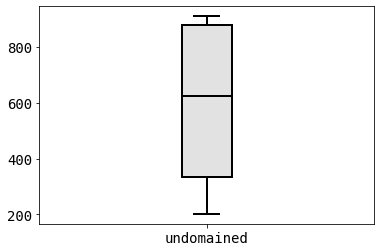

In [41]:
# *****************BOX PLOTS*****************************************************************

# This function sets up the properties of all plots
def setter(bp, c):

    for box in bp["boxes"]:
        box.set(color="#000000", linewidth=2)
        box.set(facecolor=c)

    for whisker in bp["whiskers"]:
        whisker.set(color="#000000", linewidth=2)

    for cap in bp["caps"]:
        cap.set(color="#000000", linewidth=2)

    for median in bp["medians"]:
        median.set(color="#000000", linewidth=2)

    for flier in bp["fliers"]:
        flier.set(marker="D", markerfacecolor="#000000", alpha=1)


# This function gets all the stats for the boxplots
def get_box_plot_data(bp):
    rows_list = []
    for i in range(len(colour_names)):
        dict1 = {}
        dict1["label"] = colour_names[i]
        dict1["lower_whisker"] = bp["whiskers"][i * 2].get_ydata()[1]
        dict1["lower_quartile"] = bp["boxes"][i].get_ydata()[1]
        dict1["median"] = bp["medians"][i].get_ydata()[1]
        dict1["upper_quartile"] = bp["boxes"][i].get_ydata()[2]
        dict1["upper_whisker"] = bp["whiskers"][(i * 2) + 1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)


boxplots = {}
for y in range(0, len(colour_names), 1):
    cm.figure()  # creates a figure
    cm.ticklabel_format(axis="y", style="plain")
    boxplots["bp{0}".format(y)] = cm.boxplot(
        values[y], patch_artist=True, labels=[colour_names[y]]
    )
    value_at_index = list(boxplots.values())[y]
    setter(value_at_index, colours[y])

cm.show()
# print(boxplots)
# for i in boxplots:
#     get_box_plot_data(boxplots[i])